# **Overview:**
In this section, we will perform some data preprocessing to deal with outliers and multicollinearity. To resolve these issues, the **PCA technique** will be used, as well as some variations of it, such as **Robust PCA** and **Probabilistic PCA**. Finally, the new sets will be used for model training and new data prediction.

Goal of this analysis is to evaluate the new models' performance and compare it with that of the baseline.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading and storing the training-testing and validation set:
train = pd.read_csv("CS98XClassificationTrain.csv")
train = train.drop(['Id','artist','title'], axis = 1) 
train = train.dropna()
train = train.reset_index()
train = train.drop(["index"], axis = 1)

test = pd.read_csv("CS98XClassificationTest.csv")
test = test.drop(['Id','artist','title'], axis = 1)
test = test.dropna()
test = test.reset_index()
test = test.drop(["index"], axis = 1)

test2 = pd.read_csv('CS98XRegressionTest.csv')
test2 = test2.dropna()
validation_test = test2["top genre"]

A step we missed in the Baseline file, is to check whether any 'top genres' appear exclusively to the test set. If there are any, that will be an issue for our Classification model, since a model cannot predict classes it has not previously been trained on.

In [3]:
train_genres = train['top genre'].unique()
test_genres = test2['top genre'].unique()
data_list = []
n = 0
# Loop through the genres of the test set:
for element in test_genres:
    # Check if the genre is not present in the trin set
    if element not in train_genres:
        data_list.append(element)  # Store the missing genres into the data_list array

missing_genres = pd.DataFrame(data_list, columns = ['Missing Song Genres'])

# Finally, checking how many rows have a song genre which does not exist in the training set:
for element in test2['top genre']:
    if element in data_list:
        n = n + 1
        
print("Unique song genres not present in train data:")
print(missing_genres)
print()
print("Number of unique song genres not present in train data:", len(data_list))
print()
print("Total number of song genres not present in train data:", n)

Unique song genres not present in train data:
    Missing Song Genres
0              big beat
1      appalachian folk
2             hollywood
3        cowboy western
4       native american
5   alternative country
6   classic country pop
7           beach music
8           modern rock
9       dirty south rap
10           diva house
11          jazz fusion

Number of unique song genres not present in train data: 12

Total number of song genres not present in train data: 14


The above 12 classes belong only to the test set. As a result, a total of 14 rows of the test set are not possible to be predicted by any model, thus limiting the maximum total accuracy which can be achieved.

In fact, the max possible songs which can be identified are 99 out of 113 making the highest possible accuracy to be 0.8761.

# **PCA utilities:**
Principal Component Analysis (PCA) offers several benefits in data analysis and machine learning.

A) PCA helps in reducing the number of features (dimensions) in a dataset while preserving most of the information. PCA extracts a set of orthogonal features (principal components) that are linear combinations of the original features. These new features are often more informative and can be used as input for downstream machine learning models.

B) PCA can mitigate multicollinearity issues by transforming correlated features into a set of uncorrelated principal components, which can improve the stability and interpretability of regression and classification models.

C) PCA as a preprocessing step can lead to improved performance of machine learning models.

However, outliers can influence the principal components calculated by PCA. Outlier detection and preprocessing steps are often performed before applying PCA to mitigate their impact. Neverthless, there are alternative dimensionality reduction techniques that are more robust to outliers, such as robust PCA. Furthermore, datasets with class imbalance or unequal representation of different groups, PCA may not capture the underlying structure well, especially if the minority class is underrepresented. Finally, PCA assumes linear relationships between variables. If the relationships in the data are nonlinear, PCA may not capture the underlying structure effectively. In such cases, nonlinear dimensionality reduction techniques like t-SNE or Isomap might be more appropriate.

# **Data Inspection:**
In this section, we will examine the data before data preprocessing because it allows identification of data characteristics, anomalies, and patterns crucial for making informed decisions about the most appropriate preprocessing techniques to apply. In this analysis, data will be examined for outlier detection and multicollinearity:

#### **A) Outlier Detection:**

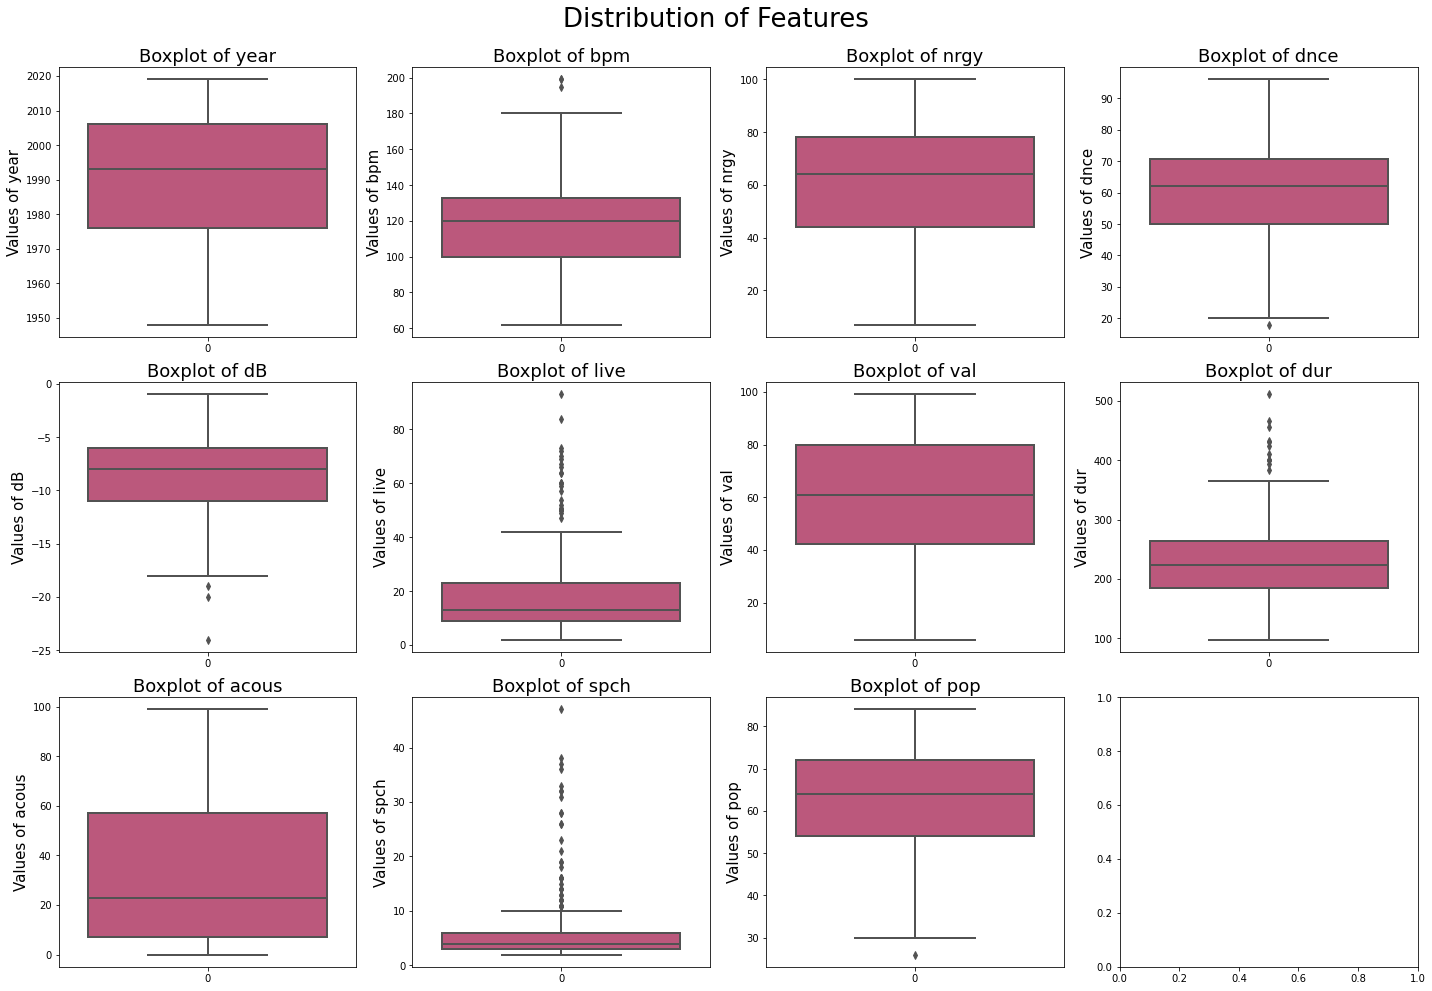

In [4]:
# Set up the subplot grid and figure size
fig, ax = plt.subplots(3, 4, figsize=(20, 14))

# Define the columns to be plotted
columns = ['year', 'bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop']

# Loop through each column and create a boxplot
for i, column in enumerate(columns):
    sns.boxplot(data=train[column], ax=ax[i // 4, i % 4], palette='plasma', linewidth=2)

    # Set title, x-axis label, and y-axis label
    ax[i // 4, i % 4].set_title(f'Boxplot of {column}', fontsize=18)
    ax[i // 4, i % 4].set_xlabel('', fontsize=16)  # No x-axis label needed
    ax[i // 4, i % 4].set_ylabel(f'Values of {column}', fontsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

# Add title for all subplots according to each variable name
fig.suptitle('Distribution of Features', fontsize=26)

# Adjust title layout to prevent overlap with the subplots
plt.subplots_adjust(top=0.92)

plt.show()

The independent variables of "live", "dur", "spch" have plenty of outliers. In this analysis we will not remove them, as the size of our training data is already small enough, containing only 438 rows of data. Instead, we will use preprocessing techniques to handle the outliers, such as Data Transformations or performing statistical methods less sensitive to outliers such as Robust PCA.

#### **B) Multicollinearity Examining:**

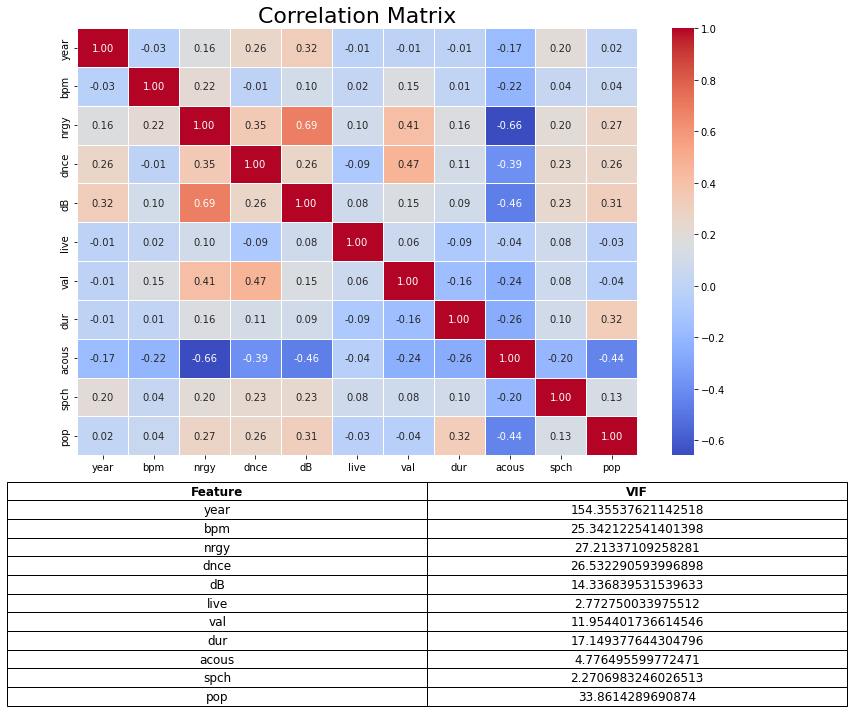

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.gridspec import GridSpec

# Compute correlation matrix
numerical = train.drop(['top genre'], axis=1)
correlation_matrix = numerical.corr()

# Calculate VIF values for each predictor variable
vif_data = pd.DataFrame()
vif_data["Feature"] = numerical.columns
vif_data["VIF"] = [variance_inflation_factor(numerical.values, i) for i in range(numerical.shape[1])]

# Create a grid layout for the plot
fig = plt.figure(figsize = (15, 10))
gs = GridSpec(2, 2, width_ratios = [3, 1], height_ratios = [2, 1])

# Visualize correlation matrix using heatmap
ax1 = plt.subplot(gs[0, 0])
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths=0.5, ax=ax1)
ax1.set_title("Correlation Matrix", fontsize=22)

# Display VIF values on a table for clearer visualization
ax2 = plt.subplot(gs[1, 0])
ax2.axis('off')  # Hide axis
table = ax2.table(cellText = vif_data.values, colLabels = vif_data.columns, loc = 'center', cellLoc = 'center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Scale table for better readability

# Make table titles bold
for (i, j), cell in table.get_celld().items():
    if (i == 0 or j == -1):
        cell.set_text_props(fontweight='bold')

plt.tight_layout()
plt.show()

Variables of "live", "acous" and "spch" are the only ones without signs of multicollinearity since they have a VIF value **< 5**. The rest of the variables present a VIF value **above 10**, indicator of potentially problematic levels of multicollinearity. To address this issue, different PCA techniques will be performed.

# **PCA Techniques:**
In this section, we will try different PCA techniques to evaluate how they affect model performance.

#### **A) Normal PCA + Robust PCA:**
Robust PCA will be perfromed on **"live"**, **"dur"** and **"spch"** variables which is more suited dealing with outliers. The rest of the independent variables will be processed using normal PCA.

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

# Define the columns for each set
columns_set1 = ['live', 'dur', 'spch']
columns_set2 = ['year', 'bpm', 'nrgy', 'dnce', 'dB', 'val', 'acous', 'pop']

# Split X into two sets
X_set1 = train[columns_set1]
X_set2 = train[columns_set2]

# Robust scaling and PCA for both set containing 'live', 'dur', 'spch' and for set containing other variables
scaler = RobustScaler()
X_set1_scaled = scaler.fit_transform(X_set1)
X_set2_scaled = scaler.fit_transform(X_set2)

robust_pca = PCA(n_components = 3)  # Adjust the number of components as needed
X_set1_pca = robust_pca.fit_transform(X_set1_scaled)
X_set1_df = pd.DataFrame(X_set1_pca, columns=['RPCA_lds1', 'RPCA_lds2', 'RPCA_lds3'])

# PCA for set containing other variables
pca = PCA(n_components = 6)  # Adjust the number of components as needed
X_set2_pca = pca.fit_transform(X_set2_scaled)
X_set2_df = pd.DataFrame(X_set2_pca, columns = ['PCA_rest1', 'PCA_rest2', 'PCA_rest3', 'PCA_rest4', 'PCA_rest5', 'PCA_rest6'])

# Concatenate the PCA results
X_final = pd.concat([X_set1_df, X_set2_df], axis = 1)

X_final

,RPCA_lds1,RPCA_lds2,RPCA_lds3,PCA_rest1,PCA_rest2,PCA_rest3,PCA_rest4,PCA_rest5,PCA_rest6
0,-0.955273,-0.056038,-0.977018,1.545341,-0.094773,0.292226,-0.926880,-0.416151,0.401224
1,-0.897322,-0.324960,0.185855,-0.060009,-0.530875,0.260024,0.933057,0.248998,0.079131
2,-0.905252,-0.288160,0.026725,1.189174,1.570884,0.346340,1.375276,-0.653717,-0.483648
3,-0.920453,-0.038735,-0.418943,0.481752,0.140084,0.440047,0.203754,0.146026,0.371733
4,0.081974,-0.379943,-0.160031,-0.463475,-0.702664,0.875413,0.218101,-0.904932,-0.118943
...,...,...,...,...,...,...,...,...,...
433,-0.596780,-0.461660,-0.261435,3.589821,-0.170737,0.527443,-0.074471,0.873953,-0.298398
434,-0.914153,0.647581,-0.855128,0.060532,1.054059,-1.081184,-0.332281,-0.176794,-0.298233
435,2.815294,-0.137997,0.612808,-0.947644,0.921812,0.128097,0.868359,-0.972115,0.389482
436,0.701358,-0.738266,-0.687388,-1.540650,1.252481,-0.267277,-0.297288,-0.136460,0.080346


The same process will be applied to the test set as well:

In [7]:
# Define the columns for each set
columns_set1 = ['live', 'dur', 'spch']
columns_set2 = ['year', 'bpm', 'nrgy', 'dnce', 'dB', 'val', 'acous', 'pop']

# Split X into two sets
test_set1 = test[columns_set1]
test_set2 = test[columns_set2]

# Robust scaling and PCA for both set containing 'live', 'dur', 'spch' and for set containing other variables
scaler = RobustScaler()
test_set1_scaled = scaler.fit_transform(test_set1)
test_set2_scaled = scaler.fit_transform(test_set2)

robust_pca = PCA(n_components = 3)  # Adjust the number of components as needed
test_set1_pca = robust_pca.fit_transform(test_set1_scaled)
test_set1_df = pd.DataFrame(test_set1_pca, columns = ['RPCA_lds1', 'RPCA_lds2', 'RPCA_lds3'])

# PCA for set containing other variables
pca = PCA(n_components = 6)  # Adjust the number of components as needed
test_set2_pca = pca.fit_transform(test_set2_scaled)
test_set2_df = pd.DataFrame(test_set2_pca, columns = ['PCA_rest1', 'PCA_rest2', 'PCA_rest3', 'PCA_rest4', 'PCA_rest5', 'PCA_rest6'])

# Concatenate the PCA results
test_final = pd.concat([test_set1_df, test_set2_df], axis = 1)

test_final

,RPCA_lds1,RPCA_lds2,RPCA_lds3,PCA_rest1,PCA_rest2,PCA_rest3,PCA_rest4,PCA_rest5,PCA_rest6
0,4.389753,3.356296,-0.203205,-1.732920,1.092448,-0.442573,0.187962,-0.047063,-0.300303
1,-1.167374,-0.506524,0.831239,1.902643,1.547306,-0.275453,0.373927,-0.318439,0.787960
2,-1.166640,-0.440282,-0.581514,0.753435,-0.291980,2.510114,1.306120,0.109380,0.029021
3,-0.596009,1.286737,-0.128108,-0.700684,-0.279920,-1.022301,0.359233,-0.147004,0.677900
4,-1.083194,0.195816,-0.909089,0.740579,-0.578435,-0.771869,0.687638,-0.764513,1.017879
...,...,...,...,...,...,...,...,...,...
108,13.618777,-0.548546,-0.297870,-0.867114,0.468789,0.409209,-0.365870,-0.374795,0.214863
109,-1.182840,-0.580420,-0.130951,-0.973783,-0.410372,-1.434953,0.694849,0.210074,0.313408
110,6.786926,-1.359413,0.297135,-0.919253,-1.144011,0.880404,-0.562413,-0.363361,-0.390843
111,2.475784,-0.923461,0.747482,-1.480993,0.263963,0.156507,-0.253722,0.643671,-0.175091


In [8]:
Y = train.loc[:, 'top genre']
X_train, X_test, Y_train, Y_test = train_test_split(X_final, Y, test_size = 0.2, random_state = 15)

In [9]:
tree_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
ovr_clf = OneVsRestClassifier(log_clf)
rnd_clf = RandomForestClassifier()
kn_clf = KNeighborsClassifier()
svm_clf = SVC()
mlp_clf = MLPClassifier()
gnb_clf = GaussianNB()

In [10]:
for clf in (log_clf, rnd_clf, svm_clf, kn_clf, mlp_clf, tree_clf, ovr_clf, gnb_clf):
    clf.fit(X_train, Y_train)
    ypred = clf.predict(X_test)
    print(clf.__class__.__name__, ":", accuracy_score(Y_test, ypred))

LogisticRegression : 0.3181818181818182
RandomForestClassifier : 0.3068181818181818
SVC : 0.36363636363636365
KNeighborsClassifier : 0.20454545454545456
MLPClassifier : 0.2840909090909091
DecisionTreeClassifier : 0.13636363636363635
OneVsRestClassifier : 0.32954545454545453
GaussianNB : 0.23863636363636365


In [11]:
final_predictions1 = log_clf.predict(test_final)
final_predictions2 = rnd_clf.predict(test_final)
final_predictions3 = svm_clf.predict(test_final)
final_predictions4 = kn_clf.predict(test_final)
final_predictions5 = mlp_clf.predict(test_final)
final_predictions6 = tree_clf.predict(test_final)
final_predictions7 = ovr_clf.predict(test_final)
final_predictions8 = gnb_clf.predict(test_final)

In [12]:
accuracy1 = accuracy_score(validation_test, final_predictions1)
accuracy2 = accuracy_score(validation_test, final_predictions2)
accuracy3 = accuracy_score(validation_test, final_predictions3)
accuracy4 = accuracy_score(validation_test, final_predictions4)
accuracy5 = accuracy_score(validation_test, final_predictions5)
accuracy6 = accuracy_score(validation_test, final_predictions6)
accuracy7 = accuracy_score(validation_test, final_predictions7)
accuracy8 = accuracy_score(validation_test, final_predictions8)

print("Accuracy of the Logistic Regression model is:", accuracy1)
print("Accuracy of the Random Forest model is:", accuracy2)
print("Accuracy of the Support Vector model is:", accuracy3)
print("Accuracy of the K-Nearest Neighbors model is:", accuracy4)
print("Accuracy of the Multilayer Perceptron model is:", accuracy5)
print("Accuracy of the Decision Tree model is:", accuracy6)
print("Accuracy of the OneVSRest model is:", accuracy7)
print("Accuracy of the Gaussian Naive Bayes model is:", accuracy8)

Accuracy of the Logistic Regression model is: 0.34513274336283184
Accuracy of the Random Forest model is: 0.2920353982300885
Accuracy of the Support Vector model is: 0.336283185840708
Accuracy of the K-Nearest Neighbors model is: 0.22123893805309736
Accuracy of the Multilayer Perceptron model is: 0.2743362831858407
Accuracy of the Decision Tree model is: 0.08849557522123894
Accuracy of the OneVSRest model is: 0.36283185840707965
Accuracy of the Gaussian Naive Bayes model is: 0.24778761061946902


We see an increase in accuracy, compared to the baseline models, with the highest performing model being the **A) OneVSRest model** , producing an accuracy of **0.362** on unknown data. Following we have the **B) Logistic Regression model** and the **C) Support Vector Machine model** producing **0.345** and **0.336** accuracies respectively.

#### **B) PROBABILISTIC PCA:**
Compared to standard PCA, Probabilistic PCA has the ability to provide uncertainty estimates for the inferred principal components, allowing for more informative and robust analyses in the presence of noise. In this section, we will perform Probabilistic PCA with dimensionality reduction to all 11 numerical variables of the dataset after we successfully scaled the data beforehand using the Standard Scaler.

In [13]:
scaler = StandardScaler()
X = train.drop(['top genre'], axis=1)
X_scaled = scaler.fit_transform(X)

# Initialize PCA with the desired number of components
n_components = 8  # Adjust as needed
pca = PCA(n_components=n_components, svd_solver='full')

# Fit PCA to the standardized data
pca.fit(X_scaled)

# Retrieve the estimated latent variables (principal components) and noise
Z = pca.transform(X_scaled)  # Latent variables
noise_variance = pca.noise_variance_  # Noise variance

# Compute the reconstructed data from the latent variables
X_reconstructed = Z.dot(pca.components_) + pca.mean_

# As usual, the same process will be applied to the test set as well
test_scaled = scaler.fit_transform(test)

# Initialize PCA with the desired number of components
n_components = 8  # Adjust as needed
pca = PCA(n_components=n_components, svd_solver='full')

# Fit PCA to the standardized data
pca.fit(test_scaled)

# Retrieve the estimated latent variables (principal components) and noise
Z_test = pca.transform(test_scaled)  # Latent variables
noise_variance = pca.noise_variance_  # Noise variance

# Compute the reconstructed data from the latent variables
test_reconstructed = Z_test.dot(pca.components_) + pca.mean_

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reconstructed, Y, test_size = 0.2, random_state = 15)

In [15]:
tree_clf = DecisionTreeClassifier()
log_clf = LogisticRegression()
ovr_clf = OneVsRestClassifier(log_clf)
rnd_clf = RandomForestClassifier()
kn_clf = KNeighborsClassifier()
svm_clf = SVC()
mlp_clf = MLPClassifier()
gnb_clf = GaussianNB()

In [16]:
for clf in (log_clf, rnd_clf, svm_clf, kn_clf, mlp_clf, tree_clf, ovr_clf, gnb_clf):
    clf.fit(X_train, Y_train)
    ypred = clf.predict(X_test)
    print(clf.__class__.__name__, ":", accuracy_score(Y_test, ypred))

LogisticRegression : 0.32954545454545453
RandomForestClassifier : 0.3068181818181818
SVC : 0.3522727272727273
KNeighborsClassifier : 0.18181818181818182
MLPClassifier : 0.29545454545454547
DecisionTreeClassifier : 0.20454545454545456
OneVsRestClassifier : 0.32954545454545453
GaussianNB : 0.25


In [17]:
final_predictions1 = log_clf.predict(test_reconstructed)
final_predictions2 = rnd_clf.predict(test_reconstructed)
final_predictions3 = svm_clf.predict(test_reconstructed)
final_predictions4 = kn_clf.predict(test_reconstructed)
final_predictions5 = mlp_clf.predict(test_reconstructed)
final_predictions6 = tree_clf.predict(test_reconstructed)
final_predictions7 = ovr_clf.predict(test_reconstructed)
final_predictions8 = gnb_clf.predict(test_reconstructed)

In [18]:
accuracy1 = accuracy_score(validation_test, final_predictions1)
accuracy2 = accuracy_score(validation_test, final_predictions2)
accuracy3 = accuracy_score(validation_test, final_predictions3)
accuracy4 = accuracy_score(validation_test, final_predictions4)
accuracy5 = accuracy_score(validation_test, final_predictions5)
accuracy6 = accuracy_score(validation_test, final_predictions6)
accuracy7 = accuracy_score(validation_test, final_predictions7)
accuracy8 = accuracy_score(validation_test, final_predictions8)

print("Accuracy of the Logistic Regression model is:", accuracy1)
print("Accuracy of the Random Forest model is:", accuracy2)
print("Accuracy of the Support Vector model is:", accuracy3)
print("Accuracy of the K-Nearest Neighbors model is:", accuracy4)
print("Accuracy of the Multilayer Perceptron model is:", accuracy5)
print("Accuracy of the Decision Tree model is:", accuracy6)
print("Accuracy of the OneVSRest model is:", accuracy7)
print("Accuracy of the Gaussian Naive Bayes model is:", accuracy8)

Accuracy of the Logistic Regression model is: 0.35398230088495575
Accuracy of the Random Forest model is: 0.30973451327433627
Accuracy of the Support Vector model is: 0.3185840707964602
Accuracy of the K-Nearest Neighbors model is: 0.21238938053097345
Accuracy of the Multilayer Perceptron model is: 0.3185840707964602
Accuracy of the Decision Tree model is: 0.19469026548672566
Accuracy of the OneVSRest model is: 0.36283185840707965
Accuracy of the Gaussian Naive Bayes model is: 0.23893805309734514


This method produces identical results with the previous one. Compared to the baseline models, the highest performing model is the **A) OneVSRest model**, producing an accuracy of **0.362** on unknown data. Following we have the **B) Logistic Regression model** and the **C) Support Vector Machine model** producing **0.353** and **0.318** accuracies respectively.

Interesting, in this case, are the **Random Forest** and the **Multilayer Perceptron** models which show an increase compared with the previous PCA method producing accuracies of **0.309** and **0.318** respectively.

Moreover, by employing Probabilistic PCA, we achieve a more parsimonious representation with fewer components, culminating in a final dataset composed of only **8 components**, thus enhancing computational efficiency and interpretability while preserving essential information.